In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import ElasticNet
from tqdm import tqdm


In [2]:
data_folder = r"C:\Users\Olesia\Downloads\DAIS\data"
json_files = glob.glob(os.path.join(data_folder, "*.json"))

print("Найдено JSON-файлов:", len(json_files))

tracks_list = []

for file_path in tqdm(json_files[:100], desc="Обработка JSON-файлов"):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for pl in data.get('playlists', []):
                pid = pl['pid']
                for track in pl.get('tracks', []):
                    tracks_list.append({
                        'playlist_id': pid,
                        'track_name': track['track_name'],
                        'track_uri': track['track_uri'],
                        'artist_name': track['artist_name'],
                        'album_name': track['album_name']
                    })
    except MemoryError:
        print("MemoryError при чтении файла:", file_path)
    except Exception as e:
        print("Ошибка при обработке файла:", file_path, e)

df = pd.DataFrame(tracks_list)
print("Общее количество треков:", len(df))
print("Пример данных:")
display(df.head())


Найдено JSON-файлов: 388


Обработка JSON-файлов: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Общее количество треков: 6685101
Пример данных:


,playlist_id,track_name,track_uri,artist_name,album_name
0,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,The Cookbook
1,0,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,In The Zone
2,0,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Dangerously In Love (Alben für die Ewigkeit)
3,0,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Justified
4,0,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,Hot Shot


EDA и обработка

Количество уникальных треков: 679889
Количество уникальных артистов: 107167
Количество плейлистов: 100000

Пропуски по колонкам:
playlist_id    0
track_name     0
track_uri      0
artist_name    0
album_name     0
dtype: int64

Количество дубликатов: 89206


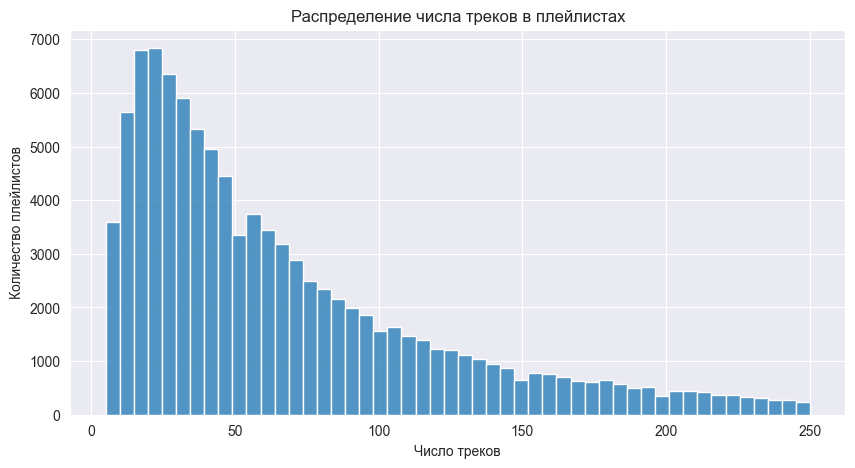

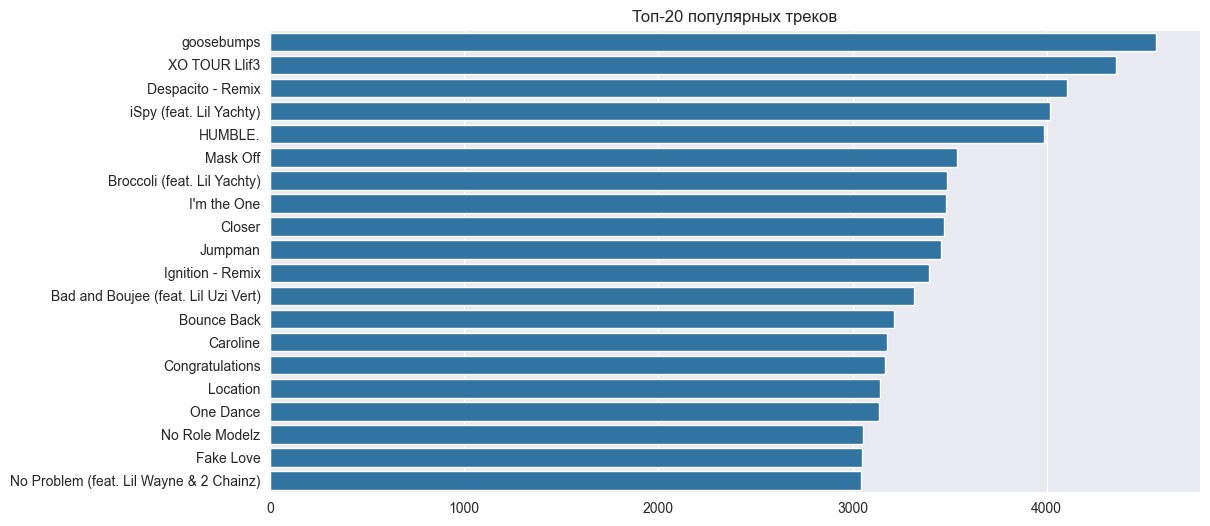

In [3]:
print("Количество уникальных треков:", df['track_uri'].nunique())
print("Количество уникальных артистов:", df['artist_name'].nunique())
print("Количество плейлистов:", df['playlist_id'].nunique())


print("\nПропуски по колонкам:")
print(df.isna().sum())
print("\nКоличество дубликатов:", df.duplicated().sum())


playlist_sizes = df.groupby('playlist_id').size()
plt.figure(figsize=(10, 5))
sns.histplot(playlist_sizes, bins=50)
plt.title("Распределение числа треков в плейлистах")
plt.xlabel("Число треков")
plt.ylabel("Количество плейлистов")
plt.show()


top_tracks = df['track_uri'].value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_tracks.values, y=df[df['track_uri'].isin(top_tracks.index)]['track_name'].unique())
plt.title("Топ-20 популярных треков")
plt.show()


In [4]:
playlist_ids = df['playlist_id'].unique()
train_ids, test_ids = train_test_split(playlist_ids, test_size=0.2, random_state=42)
train_df = df[df['playlist_id'].isin(train_ids)]
test_df = df[df['playlist_id'].isin(test_ids)]

MostPop

In [5]:
most_pop_tracks = train_df['track_uri'].value_counts()
top_10_most_pop = most_pop_tracks.head(10).index.tolist()

UserKnn and ItemKnn

In [6]:

from scipy.sparse import csr_matrix
from collections import Counter
import numpy as np


playlist_ids = train_df['playlist_id'].unique()
track_ids = train_df['track_uri'].unique()
playlist_index = {pid: i for i, pid in enumerate(playlist_ids)}
track_index = {tid: i for i, tid in enumerate(track_ids)}

rows = train_df['playlist_id'].map(playlist_index).values
cols = train_df['track_uri'].map(track_index).values
data = np.ones(len(train_df), dtype=np.int8)
sparse_matrix = csr_matrix((data, (rows, cols)), shape=(len(playlist_ids), len(track_ids)))


def topn_user_sim(target_idx, sparse_matrix, top_n=5):
    target_row = sparse_matrix[target_idx]
    sims = sparse_matrix.dot(target_row.T).toarray().ravel()
    norms = np.sqrt(sparse_matrix.power(2).sum(axis=1).A1) * np.sqrt(target_row.power(2).sum())
    sims = sims / (norms + 1e-9)
    top_indices = sims.argsort()[::-1][1:top_n+1]
    return top_indices

def userknn_recommend(pid, top_n=10):
    if pid not in playlist_index:
        return []
    target_idx = playlist_index[pid]
    neighbor_idx = topn_user_sim(target_idx, sparse_matrix, top_n=5)
    rec_scores = sparse_matrix[neighbor_idx].sum(axis=0).A1
    rec_indices = rec_scores.argsort()[::-1]
    rec_tracks = [track_ids[i] for i in rec_indices if sparse_matrix[target_idx, i]==0]
    return rec_tracks[:top_n]

def itemknn_recommend(pid, top_n=10):
    if pid not in playlist_index:
        return []
    target_idx = playlist_index[pid]
    user_row = sparse_matrix[target_idx]
    recs = Counter()
    user_tracks = user_row.nonzero()[1]
    for t_idx in user_tracks:
        track_col = sparse_matrix[:, t_idx]
        sim = sparse_matrix.T.dot(track_col).toarray().ravel()
        top_indices = sim.argsort()[::-1][1:6]
        for i in top_indices:
            recs[track_ids[i]] += sim[i]
    return [t for t,_ in recs.most_common(top_n)]


SLIM

In [7]:
from sklearn.linear_model import ElasticNet
from tqdm import tqdm
from scipy.sparse import lil_matrix

top_n_tracks = 50
top_tracks_counts = train_df['track_uri'].value_counts().head(top_n_tracks)
slim_track_ids = top_tracks_counts.index.tolist()

slim_model_dict = {}

X_lil = sparse_matrix.tolil()

for t_id in tqdm(slim_track_ids, desc="Обучение SLIM"):
    idx = track_index[t_id]
    y = X_lil[:, idx].toarray().ravel()
    X_tmp = X_lil.copy()
    X_tmp[:, idx] = 0
    enet = ElasticNet(alpha=1.0, l1_ratio=0.5, positive=True, max_iter=100)
    enet.fit(X_tmp, y)
    slim_model_dict[t_id] = enet.coef_

def slim_recommend(track_uri, top_n=10):
    if track_uri not in slim_model_dict:
        return top_tracks_counts.index[:top_n].tolist()
    coefs = slim_model_dict[track_uri]
    top_indices = np.argsort(coefs)[::-1][:top_n]
    return [track_ids[i] for i in top_indices if coefs[i] > 0]


Обучение SLIM: 100%|██████████| 50/50 [23:27<00:00, 28.14s/it]


EASY

In [11]:
top_n_tracks = 30
top_tracks_counts = train_df['track_uri'].value_counts().head(top_n_tracks)
ease_track_ids = top_tracks_counts.index.tolist()
track_index_small = {t:i for i,t in enumerate(ease_track_ids)}

cols_idx = [track_index[t] for t in ease_track_ids]
sparse_small = sparse_matrix[:, cols_idx].astype(np.float32)
sparse_small.data = np.ones_like(sparse_small.data)

lambda_reg = 0.5
G = (sparse_small.T @ sparse_small).toarray() + lambda_reg * np.eye(len(ease_track_ids))
B = np.linalg.inv(G)
B = B / -np.diag(B)
np.fill_diagonal(B, 0)

def ease_recommend(pid, top_n=10):
    if pid not in playlist_index:
        return []
    idx = playlist_index[pid]
    user_row = sparse_small[idx].toarray().ravel()
    rec_scores = user_row @ B
    top_indices = np.argsort(rec_scores)[::-1][:top_n*2]
    rec_tracks = [ease_track_ids[i] for i in top_indices if user_row[i]==0]
    return rec_tracks[:top_n]


In [12]:
example_pid = np.random.choice(test_df['playlist_id'].unique(), 1)[0]
print(f"\n=== Персональные рекомендации для плейлиста {example_pid} ===")
actual_tracks = test_df[test_df['playlist_id']==example_pid]['track_uri'].tolist()
display(df[df['track_uri'].isin(actual_tracks)][['track_name','artist_name']].drop_duplicates().head(5))

methods = {
    "MostPop": top_10_most_pop,
    "SLIM": slim_recommend,
    "EASE": ease_recommend,
    "UserKNN": userknn_recommend,
    "ItemKNN": itemknn_recommend
}

for name, rec in methods.items():
    print(f"\n{name} рекомендации:")
    if callable(rec):
        rec_tracks = rec(example_pid, top_n=10)
    else:
        rec_tracks = rec[:10]
    display(df[df['track_uri'].isin(rec_tracks)][['track_name','artist_name']].drop_duplicates())



=== Персональные рекомендации для плейлиста 163070 ===


,track_name,artist_name
354,Wasted,Tiësto
993,I Wanna Get Better,Bleachers
1659,Love Myself,Hailee Steinfeld
1700,Wrapped Up,Olly Murs
1924,Never Be Like You,Flume



MostPop рекомендации:


,track_name,artist_name
1193,XO TOUR Llif3,Lil Uzi Vert
1380,iSpy (feat. Lil Yachty),KYLE
1382,HUMBLE.,Kendrick Lamar
1446,Broccoli (feat. Lil Yachty),DRAM
1985,Closer,The Chainsmokers
3022,Bad and Boujee (feat. Lil Uzi Vert),Migos
3026,Caroline,Aminé
3042,Congratulations,Post Malone
4045,Location,Khalid
4240,One Dance,Drake



SLIM рекомендации:


,track_name,artist_name
1193,XO TOUR Llif3,Lil Uzi Vert
1380,iSpy (feat. Lil Yachty),KYLE
1382,HUMBLE.,Kendrick Lamar
1446,Broccoli (feat. Lil Yachty),DRAM
1985,Closer,The Chainsmokers
3022,Bad and Boujee (feat. Lil Uzi Vert),Migos
3026,Caroline,Aminé
3042,Congratulations,Post Malone
4045,Location,Khalid
4240,One Dance,Drake



EASE рекомендации:


,track_name,artist_name
1193,XO TOUR Llif3,Lil Uzi Vert
1380,iSpy (feat. Lil Yachty),KYLE
1382,HUMBLE.,Kendrick Lamar
1446,Broccoli (feat. Lil Yachty),DRAM
1985,Closer,The Chainsmokers
3022,Bad and Boujee (feat. Lil Uzi Vert),Migos
3026,Caroline,Aminé
3042,Congratulations,Post Malone
4045,Location,Khalid
4240,One Dance,Drake



UserKNN рекомендации:


,track_name,artist_name
1193,XO TOUR Llif3,Lil Uzi Vert
1380,iSpy (feat. Lil Yachty),KYLE
1382,HUMBLE.,Kendrick Lamar
1446,Broccoli (feat. Lil Yachty),DRAM
1985,Closer,The Chainsmokers
3022,Bad and Boujee (feat. Lil Uzi Vert),Migos
3026,Caroline,Aminé
3042,Congratulations,Post Malone
4045,Location,Khalid
4240,One Dance,Drake



ItemKNN рекомендации:


,track_name,artist_name
1193,XO TOUR Llif3,Lil Uzi Vert
1380,iSpy (feat. Lil Yachty),KYLE
1382,HUMBLE.,Kendrick Lamar
1446,Broccoli (feat. Lil Yachty),DRAM
1985,Closer,The Chainsmokers
3022,Bad and Boujee (feat. Lil Uzi Vert),Migos
3026,Caroline,Aminé
3042,Congratulations,Post Malone
4045,Location,Khalid
4240,One Dance,Drake
